In [2]:
# -*- coding: utf-8 -*-
"""
.. module:: skimpy
   :platform: Unix, Windows
   :synopsis: Simple Kinetic Models in Python

.. moduleauthor:: SKiMPy team

[---------]

Copyright 2017 Laboratory of Computational Systems Biotechnology (LCSB),
Ecole Polytechnique Federale de Lausanne (EPFL), Switzerland

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIE CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

"""
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_fluxes, \
    load_concentrations, load_equilibrium_constants
from skimpy.sampling.simple_parameter_sampler import SimpleParameterSampler
from skimpy.core import *
from skimpy.mechanisms import *
from scipy.linalg import eigvals as eigenvalues
from sympy import Symbol
from skimpy.core.parameters import ParameterValues,ParameterValuePopulation
import pandas as pd
import numpy as np
import pickle

import helper as hp
from skimpy.core.parameters import load_parameter_population

#sys.path.append("..")


#Convenience factors
NCPU = 32
CONCENTRATION_SCALING = 1e9  # 1 mol to 1 mmol
TIME_SCALING = 1  # 1hr
DENSITY = 1105  # g/L
GDW_GWW_RATIO = 0.3  # Assumes 70% Water
flux_scaling_factor = 1e-3 * (GDW_GWW_RATIO * DENSITY) * CONCENTRATION_SCALING / TIME_SCALING


exp_id = 'fdp1'

met_model = 'ecoli_shikki_regulation'
# names_km = hp.load_pkl(f'models/{met_model}/parameter_names_km_fdp1.pkl')
#ss_idx = 1712

base = f"../models/{met_model}"
path_to_tmodel = f'{base}/thermo/varma_{exp_id}'
path_to_kmodel = f'{base}/kinetic/kin_varma_curated.yaml'



2024-03-06 16:03:20,700 - thermomodel_new - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-03-06 16:03:22,530 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies
2024-03-06 16:03:23,852 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_1_420', 'CYTBDpp', 'CYTBO3_4pp'] change to integer for linear dependencies


In [ ]:

tmodel = load_json_model(path_to_tmodel)
kmodel = load_yaml_model(path_to_kmodel)
# NEW STUFF #
from skimpy.io.regulation import load_enzyme_regulation
# Add regulation data to kinetic model
path_to_regulation_data = f'{base}/allosteric_regulations.csv'
df = pd.read_csv(path_to_regulation_data)
df_regulations_all = df[df['reaction_id'].isin(list(kmodel.reactions.keys()))]
df_regulations_all = df_regulations_all[df_regulations_all['regulator'].isin(list(kmodel.reactants.keys()))]
kmodel = load_enzyme_regulation(kmodel, df_regulations_all)
#-----------#
kmodel.prepare()
kmodel.compile_jacobian(sim_type=QSSA, ncpu=NCPU)

In [13]:
path_to_samples = f'{base}/steady_state_samples/steady_states.csv'

ss_idx = 1712 #[1715,1717,2392,2482,3927,4230,4241,4456, 4468]
samples = pd.read_csv(path_to_samples, header=0, index_col=0).iloc[ss_idx, 0:]

# Load ss fluxes and concentrations
flux_series = load_fluxes(samples, tmodel, kmodel,
                  density=DENSITY,
                  ratio_gdw_gww=GDW_GWW_RATIO,
                  concentration_scaling=CONCENTRATION_SCALING,
                  time_scaling=TIME_SCALING)

conc_series = load_concentrations(samples, tmodel, kmodel,
                          concentration_scaling=CONCENTRATION_SCALING)


fluxes = [flux_series[this_reaction.name] for this_reaction in
                  kmodel.reactions.values()]
concentrations = np.array([conc_series[this_variable] for
                                   this_variable in
                                   kmodel.variables.keys()])
        
# Fetch equilibrium constants
k_eq = load_equilibrium_constants(samples, tmodel, kmodel,
                          concentration_scaling=CONCENTRATION_SCALING,
                          in_place=True)

symbolic_concentrations_dict = {Symbol(k): v for k, v in conc_series.items()}

sampling_parameters = SimpleParameterSampler.Parameters(n_samples=1)
sampler = SimpleParameterSampler(sampling_parameters)

sampler._compile_sampling_functions(kmodel, symbolic_concentrations_dict, [])
model_param = kmodel.parameters
param_population = load_parameter_population(f'{base}/parameters/kinetic_params_top_10_models.hdf5')

In [25]:
param_pop = []
max_eig = []
min_eig = []
all_eigs = []
samples_to_simulate = list(param_population._index.keys())
for ix in samples_to_simulate[0:1]:
    parameter_sample = param_population[ix]
    tfa_id = int(ix.split(',')[0])
    samples = pd.read_csv(path_to_samples, header=0, index_col=0).iloc[tfa_id, 0:]

    # Load ss fluxes and concentrations
    flux_series = load_fluxes(samples, tmodel, kmodel,
                      density=DENSITY,
                      ratio_gdw_gww=GDW_GWW_RATIO,
                      concentration_scaling=CONCENTRATION_SCALING,
                      time_scaling=TIME_SCALING)

    conc_series = load_concentrations(samples, tmodel, kmodel,
                              concentration_scaling=CONCENTRATION_SCALING)


    fluxes = [flux_series[this_reaction.name] for this_reaction in
                      kmodel.reactions.values()]
    concentrations = np.array([conc_series[this_variable] for
                                       this_variable in
                                       kmodel.variables.keys()])

    # Fetch equilibrium constants
    k_eq = load_equilibrium_constants(samples, tmodel, kmodel,
                              concentration_scaling=CONCENTRATION_SCALING,
                              in_place=True)

    symbolic_concentrations_dict = {Symbol(k): v for k, v in conc_series.items()}
    
    this_jacobian = kmodel.jacobian_fun(fluxes,
                                        concentrations, parameter_sample)

    this_real_eigenvalues = sorted(np.real(eigenvalues(this_jacobian.todense())))
    max_eig.append(this_real_eigenvalues[-1])
    min_eig.append(this_real_eigenvalues[0])
    all_eigs.append(this_real_eigenvalues)

In [27]:
fluxes

[-127153.6884259239,
 -127153.6884259239,
 1083688414.9062505,
 1083688414.9062505,
 -82942517.54457112,
 -82942517.54457112,
 841750818.2040613,
 -149333.14557951855,
 -149333.14557951855,
 -140461.60016193046,
 46710956.55875495,
 2781285000.001436,
 8616493009.353008,
 22936.98889551127,
 79291196.48395438,
 -3315161668.2857594,
 -3115626513.4144273,
 838382.9438892783,
 1083688414.9062505,
 115548554.31862962,
 6101231521.136222,
 -175960.0604222565,
 -175960.0604222565,
 79291196.48395438,
 2175280183.99459,
 -140461.60016193046,
 -140461.60016193046,
 27103072.952788018,
 199535154.8712576,
 401831894.3188278,
 -164743.25020458046,
 601531792.4403213,
 2251181275.2547235,
 24992409.03010296,
 1206660000.0004475,
 94347590.96989876,
 1326000000.0,
 122324706.11834395,
 -122998310.83493981,
 -164259.56408323802,
 119340000.00002834,
 -1099142797.0397272,
 205.71290489247312,
 129792914.64458561,
 105359766.25944403,
 205085946.3315858,
 310449027.5910146,
 -3315.0000000001737,
 107

In [28]:
concentrations

array([2.56907004e+02, 2.07969685e+03, 1.22032932e+04, 6.56916958e+06,
       3.82402337e+03, 9.39613825e-01, 1.46489301e+00, 3.16227766e+01,
       1.00000000e+02, 2.54000000e+05, 7.66000000e+05, 1.53469017e+03,
       3.08264450e+06, 5.60653934e+04, 3.17683446e+05, 1.00000000e+07,
       2.75156153e+00, 7.24000000e+03, 3.59024094e+05, 3.16665514e+05,
       3.96987066e+04, 2.19700577e+04, 1.12988211e+04, 6.00247746e+02,
       5.51601900e+02, 4.14726612e+05, 3.76026418e+06, 1.14393071e+06,
       1.16121132e+06, 1.41942779e+00, 1.22506520e+00, 3.70899411e+01,
       1.40507856e+00, 1.59244058e+05, 5.30283182e+04, 9.47655720e+01,
       4.86541975e+04, 3.04786533e+06, 3.55163827e+05, 1.27535429e+05,
       2.75956283e+04, 2.44251078e+04, 2.54634976e+05, 2.13637108e+06,
       2.63453974e+06, 2.54345903e+02, 1.09093632e+07, 1.15513052e+08,
       1.56613225e+02, 2.80553743e+05, 2.55197836e+01, 6.22000000e+04,
       3.97837835e+05, 1.31551016e+06, 3.37971013e+06, 5.45207260e+04,
      

In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load HDF5 file
with h5py.File(f"{base}/parameters/kinetic_params_top_10_models.hdf5", 'r') as file:
    parameter_names = file['parameter_names'][:]
    num_sets = int(file['num_parameters_sets'][()])
    parameter_sets = [file[f'parameter_set_{i}'][:] for i in range(num_sets)]

In [31]:
# Convert parameter names to a list of strings if necessary
parameter_names = [name.decode() if isinstance(name, bytes) else name for name in parameter_names]

# Sort parameter names and corresponding values
sorted_indices = np.argsort(parameter_names)
sorted_parameter_names = np.array(parameter_names)[sorted_indices]

# Create a sorted matrix
sorted_matrix = np.array(parameter_sets)[:, sorted_indices].T


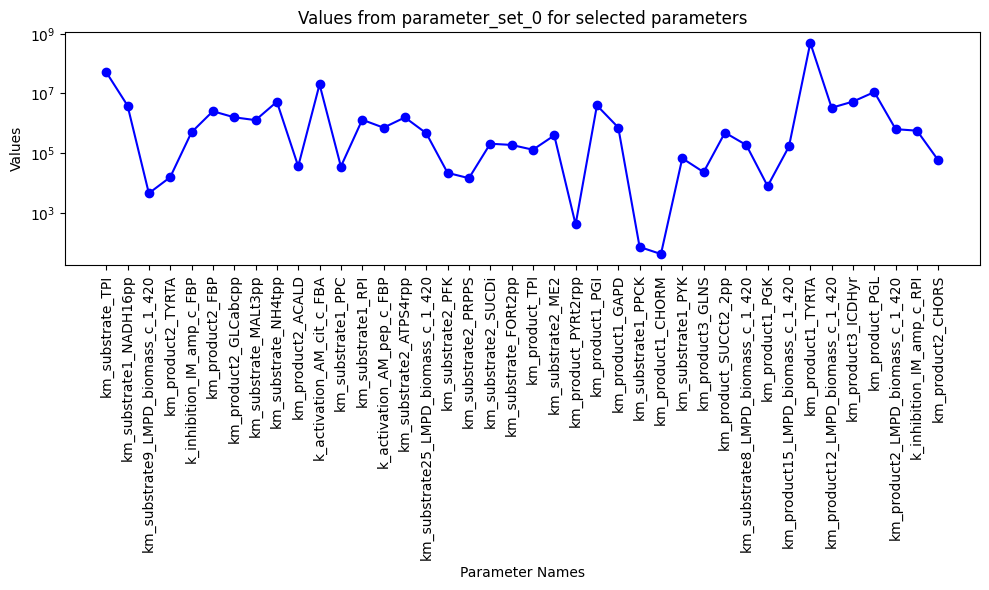

In [32]:
# Filter parameters based on the specified substrings
filtered_indices = [i for i, name in enumerate(sorted_parameter_names) if "activation" in name or "inhibition" in name or "km_" in name]

# Randomly select 40 indices from the filtered list (if there are more than 40)
if len(filtered_indices) > 40:
    selected_indices = np.random.choice(filtered_indices, 40, replace=False)
else:
    selected_indices = filtered_indices

# Extract the selected parameter names and their values from parameter_set_0
selected_parameter_names = sorted_parameter_names[selected_indices]
selected_values = sorted_matrix[selected_indices, 0]

# Plotting the selected parameters and their values
plt.figure(figsize=(10, 6))
plt.plot(selected_parameter_names, selected_values, marker='o', linestyle='-', color='b')
plt.title('Values from parameter_set_0 for selected parameters')
plt.xlabel('Parameter Names')
plt.ylabel('Values')
plt.yscale('log')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


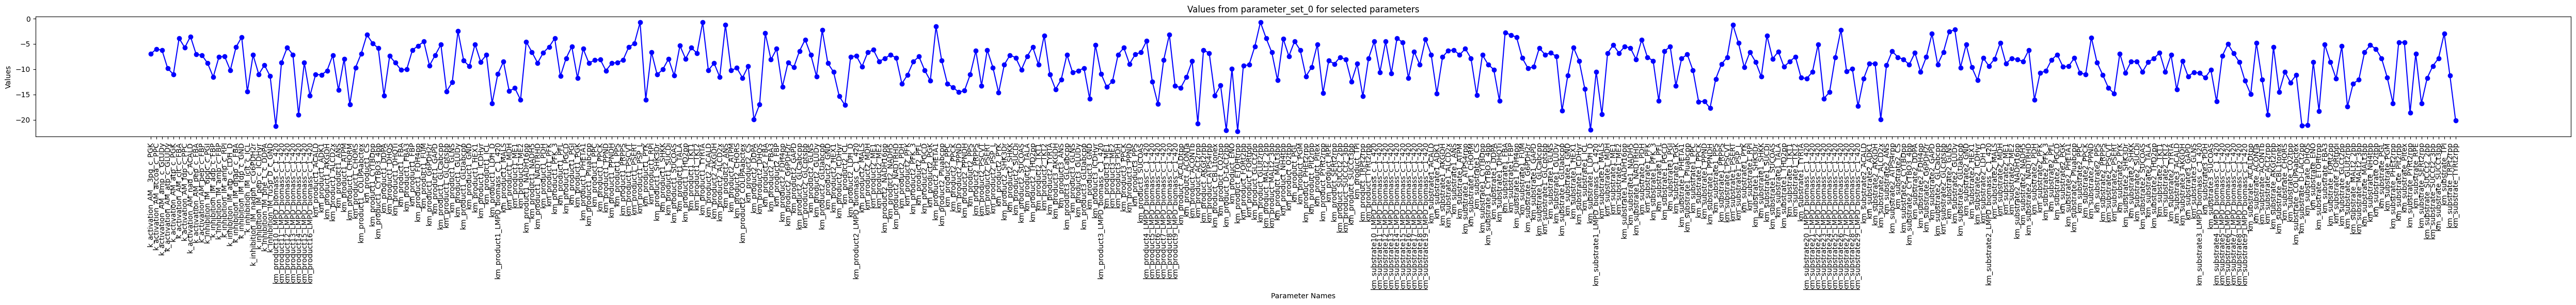

In [33]:
# Extract the selected parameter names and their values from parameter_set_0
selected_parameter_names = sorted_parameter_names[filtered_indices]
selected_values = sorted_matrix[filtered_indices, 0]

selected_values = selected_values/1e9
selected_values = np.log(selected_values)
# Plotting the selected parameters and their values
plt.figure(figsize=(50, 6))
plt.plot(selected_parameter_names, selected_values, marker='o', linestyle='-', color='b')
plt.title('Values from parameter_set_0 for selected parameters')
plt.xlabel('Parameter Names')
plt.ylabel('Values')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

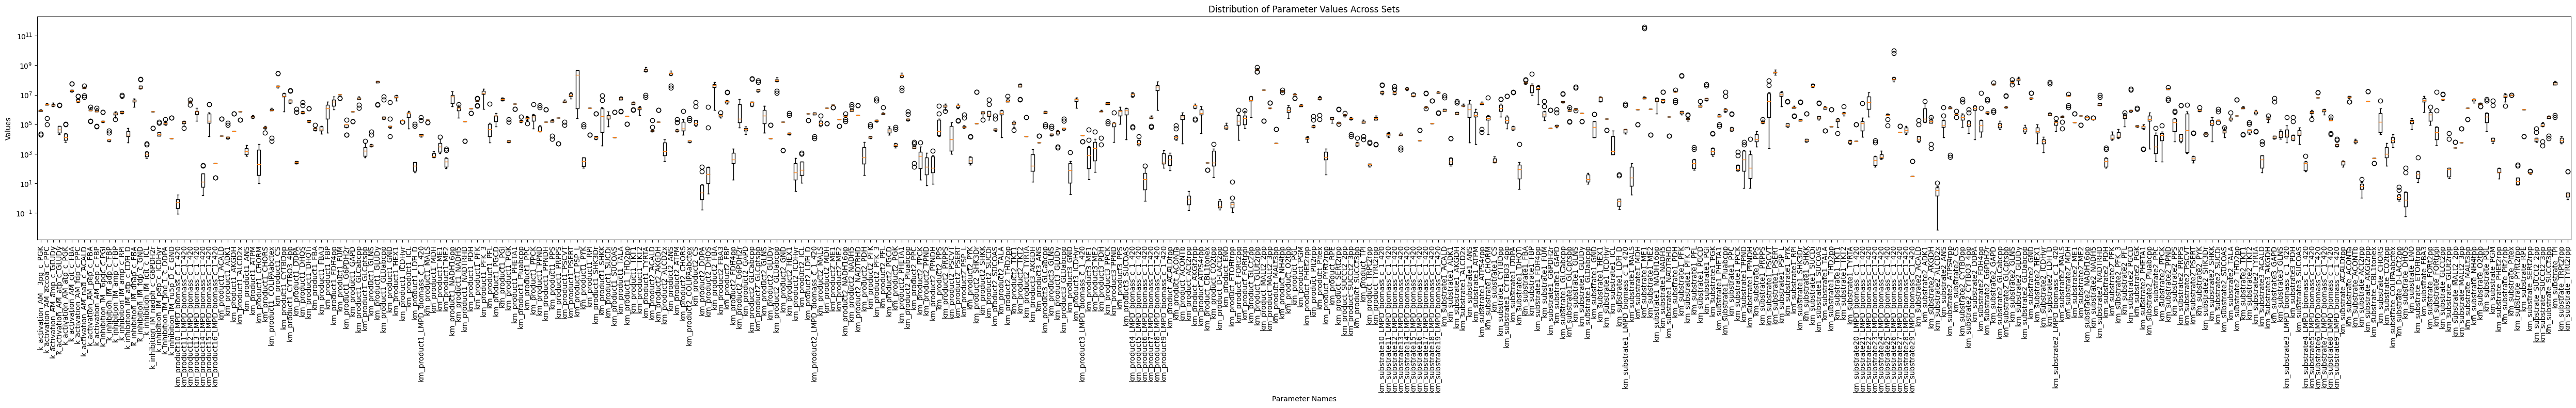

In [40]:
# Initialize a figure
plt.figure(figsize=(50, 8))

# Create a dataset for boxplot where each row corresponds to a parameter, and each column corresponds to a different set
data_for_boxplot = [np.array(parameter_sets)[:, sorted_indices[i]] for i in filtered_indices]

# Create the boxplot
plt.boxplot(data_for_boxplot, labels=selected_parameter_names)

# Add plot details
plt.xticks(rotation=90)
plt.xlabel('Parameter Names')
plt.ylabel('Values')
plt.yscale('log')
plt.title('Distribution of Parameter Values Across Sets')
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.savefig('all_parameter_sets')